<h1> <center><font color='green' > <b>AGN Redshift Predicetion for AGNDB</b></font> </center></h1>
<h1> Data Preprocessing </h1>
by Sicong Huang  <br>
<font color='blue'>Python Version: 3.6.5 <br>
AGNDB Version: 1.1.0

# THE QUESTION: <br><font color='green'>How to use ML methods to predict photometric redshift for agns in AGNDB?</font>

# Goal of preprocessing
<font color='green'>
    
- Select subsample of pure agn, where redshift and magnitudes are complete. 
- Fill in missing values if not complete.

# IMPORT LIBRARIES

In [29]:
# System
import os
import glob
from tqdm import tqdm
from IPython.display import Markdown, display, Audio
from copy import deepcopy
# Web Scraping

# Data Analysis
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from scipy import stats

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Functions

In [2]:
def sound_effect(fail=0):
    """
    Play a sound when job is finished
    """
    if fail == 0:
        sound_file = '/data/home/sicong/sounds/jobs-done_1.mp3'
        display(Audio(sound_file, autoplay=True))
    else:
        sound_file = '/data/home/sicong/sounds/oh-shit-im-sorry_0001.mp3'
        display(Audio(sound_file, autoplay=True))

In [3]:
def printmd(string):
    """
    print in markdown style
    """
    display(Markdown(string))

In [4]:
printmd("**<font color='purple'>This is a test.**")

**<font color='purple'>This is a test.**

In [5]:
def non_nan_percent(df, cols):
    '''
    This function returns the percentage 
    of non-NaN values sorted by percentage
    '''
    perc = {col:f"{len(df[col].dropna())/len(df[col])*100 :.2f} %" for col in cols}
    perc = dict(sorted(perc.items(), key=lambda item: float(item[1].split('%')[0]), reverse=True))
    return perc

In [6]:
def nan_percent(df, cols):
    '''
    This function returns the percentage 
    of NaN values sorted by percentage
    '''
    perc = {col:f"{(1-len(df[col].dropna())/len(df[col]))*100 :.2f} %" for col in cols}
    perc = dict(sorted(perc.items(), key=lambda item: float(item[1].split('%')[0]), reverse=False))
    return perc

In [7]:
def combine_columns(df, column_names):
    '''
    This function merges the columns 
    with first come first serve order
    and returns a new df series
    '''
    col = df[column_names[0]]
    for name in column_names[1:]:
        col = col.combine_first(df[name])
    return col

# Data Requirements 
Identify the necessary data content, formats and sources for initial data collection.

In [9]:
glob.glob('/data/blackbase/final/*master*')

['/data/blackbase/final/master-Redshift-store.csv',
 '/data/blackbase/final/master-Morphology-store.csv',
 '/data/blackbase/final/master-Photometry-store.csv',
 '/data/blackbase/final/master-converted-Photometry-store.csv',
 '/data/blackbase/final/master-merged-Photometry-store.csv',
 '/data/blackbase/final/master-merged-Redshift-store.csv',
 '/data/blackbase/final/master-converted-Morphology-store.csv',
 '/data/blackbase/final/master-merged-Morphology-store.csv',
 '/data/blackbase/final/master-merged-all-store.csv']

In [10]:
# master tables
morph_csv = '/data/blackbase/final/master-merged-Morphology-store.csv'
photo_csv = '/data/blackbase/final/master-merged-Photometry-store.csv'
redshift_csv = '/data/blackbase/final/master-merged-Redshift-store.csv'

# Data Collection
Perform data collection and data assessment.

In [30]:
# read into pandas dataframe
df_morph_original = pd.read_csv('/data/blackbase/final/master-merged-Morphology-store.csv');
df_photo_original = pd.read_csv('/data/blackbase/final/master-merged-Photometry-store.csv');
df_redshift_original = pd.read_csv('/data/blackbase/final/master-merged-Redshift-store.csv');

/home/jack/.pyenv/versions/3.6.5/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3,7,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jack/.pyenv/versions/3.6.5/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
printmd(f'We have {len(df_photo_original)} sources.')

We have 1436614 sources.

In [13]:
printmd(f'We have {len(df_photo_original.columns)} columns for photometry datasets.')
printmd(f'We have {len(df_redshift_original.columns)} columns for redshift datasets.')
printmd(f'We have {len(df_morph_original.columns)} columns for morphology datasets.')

We have 204 columns for photometry datasets.

We have 19 columns for redshift datasets.

We have 13 columns for morphology datasets.

# Data Preparation
Data must be prepared in a way that addresses missing or invalid values and removes duplicates, toward ensuring that everything is properly formatted.

## Feature Selection

<font color='green'>Before we move on, let's set the 'np.NaN' values in __df_morph_original__ to be 'unknown'. In this way, the classification column won't affect the sorting of master table based on missing values.

In [31]:
df_morph_original['best_class'] = df_morph_original['best_class'].replace(np.NaN, 'unknown')

<font color='green'> For photometry table, select only magnitude columns.

In [15]:
# look at all the columns we have in the original table
# with non-Nan percentage
printmd("**<font color='red'>Photometry table columns:**")
perc = non_nan_percent(df_photo_original,df_photo_original.columns)
print(*perc.items(), sep='\n')
print('-'*100)

printmd("**<font color='red'>Classification table columns:**")
perc = non_nan_percent(df_morph_original,df_morph_original.columns)
print(*perc.items(), sep='\n')
print('-'*100)

printmd("**<font color='red'>Redshift table columns:**")
perc = non_nan_percent(df_redshift_original,df_redshift_original.columns)
print(*perc.items(), sep='\n')

**<font color='red'>Photometry table columns:**

('Unnamed: 0', '100.00 %')
('Unnamed: 0.1', '100.00 %')
('Unnamed: 0.1.1', '100.00 %')
('RA', '100.00 %')
('DEC', '100.00 %')
('u_extinction', '53.33 %')
('u_mag', '51.34 %')
('r_mag', '51.33 %')
('i_mag', '51.08 %')
('g_mag', '50.81 %')
('z_mag', '50.74 %')
('e_i_mag', '50.45 %')
('e_z_mag', '50.45 %')
('e_r_mag', '50.41 %')
('e_u_mag', '50.40 %')
('e_g_mag', '47.25 %')
('r_extinction', '45.96 %')
('g_extinction', '44.89 %')
('i_extinction', '43.56 %')
('z_extinction', '43.56 %')
('W1_mag', '41.57 %')
('E_B-V', '33.97 %')
('e_rf10', '23.37 %')
('rf10', '23.37 %')
('e_rf12', '23.37 %')
('rf12', '23.37 %')
('W2_mag', '21.41 %')
('e_W1_mag', '21.38 %')
('W3_mag', '21.37 %')
('W4_mag', '21.37 %')
('e_W2_mag', '21.21 %')
('e_W4_mag', '18.30 %')
('e_W3_mag', '18.09 %')
('e_counts', '10.42 %')
('counts', '10.42 %')
('e_xf2', '10.28 %')
('xf2', '10.28 %')
('e_xf6', '10.16 %')
('xf6', '10.16 %')
('e_xf16', '10.04 %')
('xf16', '10.04 %')
('e_xf15', '9.91 %')
('xf15', '9.91 %')
('e_xf17', '9.83 

**<font color='red'>Classification table columns:**

('Unnamed: 0', '100.00 %')
('Unnamed: 0.1', '100.00 %')
('Unnamed: 0.1.1', '100.00 %')
('RA', '100.00 %')
('DEC', '100.00 %')
('best_class', '100.00 %')
('xray_class', '66.58 %')
('spec_class', '48.95 %')
('gen_class', '44.00 %')
('SED_class', '40.90 %')
('image_class', '10.88 %')
('SP_TYPE_simbad', '2.68 %')
('nan_column', '0.00 %')
----------------------------------------------------------------------------------------------------


**<font color='red'>Redshift table columns:**

('Unnamed: 0', '100.00 %')
('Unnamed: 0.1', '100.00 %')
('Unnamed: 0.1.1', '100.00 %')
('RA', '100.00 %')
('DEC', '100.00 %')
('best_Z', '52.27 %')
('f_best_Z', '52.27 %')
('q_Z', '50.37 %')
('phot_Z', '43.67 %')
('p_phot_Z', '43.60 %')
('max_phot_Z', '43.47 %')
('min_phot_Z', '42.06 %')
('spec_Z', '17.62 %')
('Z', '17.09 %')
('e_spec_Z', '13.74 %')
('e_best_Z', '13.74 %')
('nan_column', '0.00 %')
('e_phot_Z', '0.00 %')
('e_Z', '0.00 %')


<font color='green'>*best_class* column in df_morph_original and *best_Z* column in df_redshift_original are created by following order:<br>
- "spec_class" > "SDSS_image_class" > "SED_class" > "vi_class" > "optical_class" > "gen_class" > "Mtype"

In [14]:
# check if df_morph_original, df_photo_original and df_redshift_original shares the same index system,
# i.e, if the same index corresponds to the same source
if df_photo_original['RA'].equals(df_morph_original['RA']):
    print('photometry and morphology table have the same indices.')

if df_photo_original['RA'].equals(df_redshift_original['RA']):
    print('photometry and redshift table have the same indices.')

photometry and morphology table have the same indices.
photometry and redshift table have the same indices.


In [32]:
# merge with df_photo_original
df_photo_original['best_class'] = df_morph_original["best_class"]
df_photo_original['best_z'] = df_redshift_original["best_Z"]
df_photo_original['best_z_error'] = df_redshift_original["e_best_Z"]

In [33]:
df_photo_original.head(5)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Velocity_ned,Magnitude and Filter_ned,Photometry Points_ned,FLUX_SYSTEM_U_simbad,FLUX_QUAL_U_simbad,FLUX_UNIT_U_simbad,FLUX_SYSTEM_B_simbad,...,snr_r,snr_u,snr_z,snr_W1,snr_W2,snr_W3,snr_W4,best_class,best_z,best_z_error
0,0,0,0,809807.0,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,2.7010,0.0
1,1,1,1,278.0,0.9,51.0,NaN,NaN,NaN,NaN,...,4.90,1.48,3.48,33.85,34.65,30.4,5.75,galaxy,2.4150,0.0
2,2,2,2,NaN,NaN,6.0,False,False,False,False,...,2.54,1.45,2.38,23.90,15.60,3.5,0.50,galaxy,3.5100,0.0
3,3,3,3,NaN,20.3g,5.0,NaN,NaN,NaN,NaN,...,14.61,3.31,8.01,37.50,37.45,16.9,4.95,galaxy,0.7213,0.0
4,4,4,4,870897.0,20.9g,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,galaxy,2.3780,0.0


<font color='green'>Select the features we want:
    select top 5% rows and magnitude columns for pure AGN

In [150]:
useful_columns = ['RA', 'DEC', 'best_class', 'best_z', 'best_z_error', 
                  'i_mag', 'r_mag', 'z_mag', 'u_mag', 'g_mag', 'W1_mag', 'W2_mag', 'W4_mag', 'W3_mag']
df = deepcopy(df_photo_original)
df = df[useful_columns]

<font color='green'>Replace AGN=1 and non-AGN=0 in __best_class__ column.

In [94]:
df['best_class'].value_counts()

generic_agn    861791
unknown        278653
star           174484
galaxy         101868
type2            9020
type1            8301
blazar           2465
lens_system        27
false               5
Name: best_class, dtype: int64

In [151]:
df.rename(columns = {'best_class':'AGN'}, inplace = True)
df['AGN'].replace({'generic_agn':True,
                   'blazar':True,
                   'star':False,
                   'galaxy':False,
                   'type1':True,
                   'type2':True,
                   'lens_system':True,
                   'unknown': np.nan,
                   'false':False
                    }, inplace=True)

In [152]:
df['AGN']=df['AGN'].astype('float')
df = df[df['AGN'] == 1.0 ]

In [153]:
# drop class column
df = df.drop(['AGN'], axis=1)

<font color='green'>sort the df based on missing value counts where the least NaN rows are at the top and select top 10%

In [154]:
df = df.iloc[df.isnull().sum(axis=1).mul(1).argsort()]
x=round(len(df)*0.1)
print(x)
df = df.head(x)

88160


In [155]:
df.describe()

,RA,DEC,best_z,best_z_error,i_mag,r_mag,z_mag,u_mag,g_mag,W1_mag,W2_mag,W4_mag,W3_mag
count,88160.000000,88160.000000,88160.000000,88160.000000,88160.000000,88160.000000,88160.000000,88160.000000,88160.000000,88160.000000,88160.000000,88160.000000,88160.000000
mean,207.547855,26.518787,1.728520,-113.985875,19.980789,20.084266,19.855134,21.008371,20.269326,18.916382,18.534894,15.356851,17.005793
std,76.480548,19.430368,0.808535,1061.491778,1.086400,1.073851,1.080607,1.584740,1.101231,1.039404,1.129350,0.501002,0.809554
min,1.252397,-23.174169,0.008324,-9999.000000,14.516000,14.936000,10.000000,10.000000,10.000000,11.260000,11.932000,9.926000,10.972000
25%,178.529682,10.327504,1.062551,0.000000,19.155000,19.326000,19.078000,19.911248,19.512232,18.251000,17.777000,15.118000,16.549000
50%,210.533680,25.344984,1.683000,0.000000,20.044000,20.167000,19.896000,20.936623,20.361107,19.015000,18.640000,15.416000,17.192000
75%,237.174936,43.241876,2.312000,0.000000,20.764475,20.876567,20.570936,21.899000,21.083467,19.708000,19.383000,15.677000,17.582000
max,359.998774,83.923561,6.968027,0.262971,24.731572,25.003962,25.387159,27.499904,27.499904,22.362000,21.378000,16.789000,18.847000


<font color='green'> Change best_z_error value > 1 or < 0 to NaN 

In [156]:
df.loc[(df['best_z_error'] > 1.0) | (df['best_z_error'] < 0.0), 'best_z_error'] = np.nan

<font color='green'> Check the missing values again

In [157]:
perc = nan_percent(df,df.columns)
print(f'{len(perc)} columns:')
print(*perc.items(),sep='\n')

13 columns:
('RA', '0.00 %')
('DEC', '0.00 %')
('best_z', '0.00 %')
('i_mag', '0.00 %')
('r_mag', '0.00 %')
('z_mag', '0.00 %')
('u_mag', '0.00 %')
('g_mag', '0.00 %')
('W1_mag', '0.00 %')
('W2_mag', '0.00 %')
('W4_mag', '0.00 %')
('W3_mag', '0.00 %')
('best_z_error', '1.14 %')


<font color='blue'> After feature selection, we only select top 10% rows (88160) for agn. <br>
    The ML training would depend on magnitude columns only. <br>
    The range for redshift is  0.008324 -- 6.968027

## Train/dev/test set split
<font color='green'>
<ul>
  <li>We select 80% data as training set and remaining 20% as dev set.</li>
  <li>We do not have a test set for this project as extrapolation beyond redshift range of our training set is unreliable. Thus we assume that the future unseen data will follow as similar distribution as our dev set.</li>
</ul>

In [158]:
df_train, df_dev = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df))])

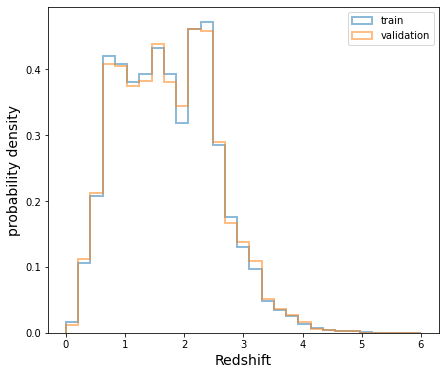

In [159]:
# check z distribution
bins_red = np.linspace(0, 6, 30)

plt.figure(figsize=(7,6))
plt.hist(df_train['best_z'], bins=bins_red, alpha=0.5, label="train", density=True, histtype='step',linewidth=2, log=False)
plt.hist(df_dev['best_z'], bins=bins_red, alpha=0.5, label="validation", density=True, histtype='step',linewidth=2, log=False)

plt.xlabel("Redshift", size=14)
plt.ylabel("probability density", size=14)

#plt.ylim([0, 2])

#plt.title("Redshift distribution")
plt.legend(loc='upper right')

#plt.savefig('z_hist.pdf')

## Save dataframes to files

<font color='green'> Read train/dev/test reports; make sure that dev and test follows the same distribution. 

In [160]:
# Train set report
profile = ProfileReport(df_train, title='AGN Redshift Predictor Training Set Report v1.1.0', minimal=True)
profile.to_file("AGNCL_train_set_report_v1.1.0.html")

# Dev set report
profile = ProfileReport(df_dev, title='AGN Redshift Predictor Validation Set Report v1.1.0', minimal=True)
profile.to_file("AGNCL_dev_set_report_v1.1.0.html")

## Data Issues:
<font color='red'>
<ul>
  <li>Limited number of magnitude columns. </li>
  <li>Redshift error data is insufficient.</li>
</ul>

<font color='green'> Save to files.

In [161]:
df_train.to_pickle('/data/blackbase/notebooks/physics/sicong/AGN_Redshift_Predictor/version_v1.1.0/version_1/agnz_train.pkl')
df_dev.to_pickle('/data/blackbase/notebooks/physics/sicong/AGN_Redshift_Predictor/version_v1.1.0/version_1/agnz_dev.pkl')

In [162]:
df_train = pd.read_pickle('/data/blackbase/notebooks/physics/sicong/AGN_Redshift_Predictor/version_v1.1.0/version_1/agnz_train.pkl')
df_dev = pd.read_pickle('/data/blackbase/notebooks/physics/sicong/AGN_Redshift_Predictor/version_v1.1.0/version_1/agnz_dev.pkl')